In [17]:
import pandas as pd
import zipfile
import glob
import matplotlib.pyplot as plt

## Step 1: Read multiple csv files zipped in one file and concatenate them.

In [2]:
#Read the zip file that contains multiple csv file
from zipfile import ZipFile
from google.colab import files
!wget 'https://raw.githubusercontent.com/Myloveismilk/vn_stock_price/main/data/archive.zip'
url = '/content/archive.zip'
df = pd.concat(
    [pd.read_csv(ZipFile(url).open(i)) for i in ZipFile(url).namelist()],
    ignore_index=True
)

--2022-10-11 10:07:31--  https://raw.githubusercontent.com/Myloveismilk/vn_stock_price/main/data/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3066402 (2.9M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]   2.92M  --.-KB/s    in 0.06s   

2022-10-11 10:07:31 (45.8 MB/s) - ‘archive.zip’ saved [3066402/3066402]



In [3]:
#See the first 5 rows of the dataset
df.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore
0,2019-07-30 00:00:00.000000000,9509.07,9535.00,9503.07,9517.75,381.293856,2019-07-30 00:29:59.999000064,3.631211e+06,3492,216.528742,2.062189e+06,0
1,2019-07-30 00:30:00.000000000,9517.03,9539.00,9507.00,9532.58,258.514869,2019-07-30 00:59:59.999000064,2.462134e+06,3133,141.887550,1.351182e+06,0
2,2019-07-30 01:00:00.000000000,9533.59,9534.00,9500.00,9500.25,275.797270,2019-07-30 01:29:59.999000064,2.624322e+06,3583,114.238457,1.087402e+06,0
3,2019-07-30 01:30:00.000000000,9500.25,9514.46,9460.71,9465.25,485.218470,2019-07-30 01:59:59.999000064,4.604004e+06,5330,225.681291,2.141459e+06,0
4,2019-07-30 02:00:00.000000000,9465.25,9488.94,9430.01,9460.42,498.669626,2019-07-30 02:29:59.999000064,4.717269e+06,6197,228.535910,2.162163e+06,0


## Step 2: Drop, rename some columns and format their types.

In [4]:
df.columns

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time',
       'Quote Asset Volume', 'Number of Trades', 'TB Base Volume',
       'TB Quote Volume', 'Ignore'],
      dtype='object')

In [5]:
#Some columns isn't necessary for predicting the bitcoin price, so let's remove it.
df = df.drop(columns= ['Close Time','Quote Asset Volume', 'Number of Trades', 'TB Base Volume','TB Quote Volume', 'Ignore'])

In [6]:
df.columns

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [7]:
#The names of all columns seem to be not in the right format, so let's change them
df = df.rename(columns= {'Open Time':'Date'})

In [8]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2019-07-30 00:00:00.000000000,9509.07,9535.00,9503.07,9517.75,381.293856
1,2019-07-30 00:30:00.000000000,9517.03,9539.00,9507.00,9532.58,258.514869
2,2019-07-30 01:00:00.000000000,9533.59,9534.00,9500.00,9500.25,275.797270
3,2019-07-30 01:30:00.000000000,9500.25,9514.46,9460.71,9465.25,485.218470
4,2019-07-30 02:00:00.000000000,9465.25,9488.94,9430.01,9460.42,498.669626


In [9]:
#Let's look at the type of each column
df['Date'] = df['Date'].astype('string')
df.dtypes

Date       string
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [10]:
#We don't need a specific time in our dataset, just need the date
def remove_time(column):
  temp = 0
  for i in range(len(column)):
    column[i] = column[i][0: 10]
    if temp <= 10:
      print(column[i])
      temp += 1

In [11]:
remove_time(df['Date'])

2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30


In [20]:
df.head()

,Date,Open,High,Low,Close,Volume
47,2019-07-30,9580.19,9587.69,9555.67,9574.21,166.478904
95,2019-07-31,10043.05,10091.73,10015.00,10080.53,602.990800
143,2019-08-01,10378.14,10397.33,10353.55,10374.99,588.452520
191,2019-08-02,10534.48,10540.45,10494.11,10523.75,395.420440
239,2019-08-03,10814.05,10821.05,10775.47,10816.86,223.173101


In [22]:
#Change date type to datetime64
df['Date'] = df['Date'].astype('datetime64')

In [23]:
# We see that there many redundant dates so we need to delele them, just keep the final price of the day.
df = df.drop_duplicates('Date',keep='last')
df.reset_index(drop = True)

,Date,Open,High,Low,Close,Volume
0,2019-07-30,9580.19,9587.69,9555.67,9574.21,166.478904
1,2019-07-31,10043.05,10091.73,10015.00,10080.53,602.990800
2,2019-08-01,10378.14,10397.33,10353.55,10374.99,588.452520
3,2019-08-02,10534.48,10540.45,10494.11,10523.75,395.420440
4,2019-08-03,10814.05,10821.05,10775.47,10816.86,223.173101
...,...,...,...,...,...,...
1151,2022-09-23,19345.98,19396.84,19231.05,19289.91,7421.450650
1152,2022-09-24,18910.03,18954.11,18870.12,18920.50,4619.476880
1153,2022-09-25,18835.49,18845.09,18730.00,18807.38,7089.962310
1154,2022-09-26,19177.09,19246.33,19171.86,19227.82,7177.860690


## Step 3: Handle Missings

In [14]:
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

There is no nan value, so we can move on to the next step.

## Step 4: Quick visualization

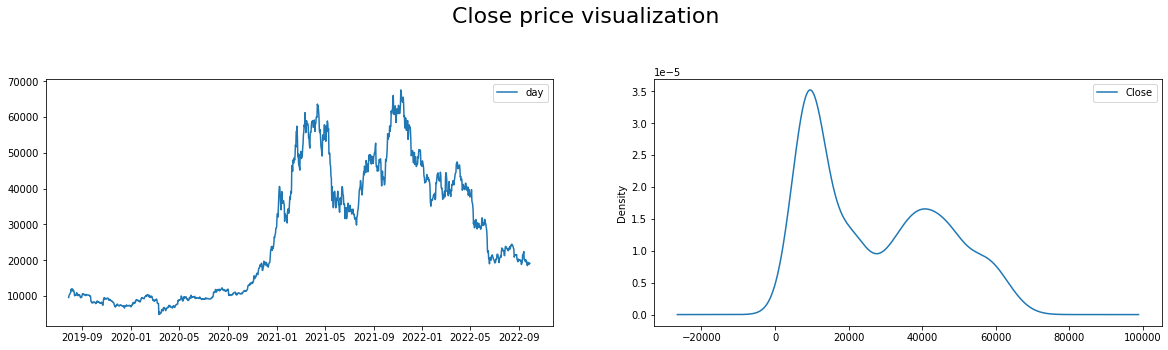

In [35]:
fig = plt.figure(figsize=[20, 10]);
plt.suptitle('Close price visualization', fontsize=22)

plt.subplot(221)
plt.plot(df['Date'], df['Close'], '-', label= 'day');
plt.legend();

plt.subplot(222)
df['Close'].plot(kind = 'kde');
plt.legend();


In [15]:
#The dataset now look fine, let's save it for future work.
# df.to_csv('bitcoin_price.csv')